In [94]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline 
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier

In [102]:
SEED = 144

# Carga de datos

In [32]:
PATH_EVENTOS    = "data\\eventos.csv"
PATH_PAGOS      = "data\\pagos.csv"
PATH_USUARIOS   = "data\\usuarios.csv"

In [33]:
eventos     = pd.read_csv(PATH_EVENTOS)
pagos       = pd.read_csv(PATH_PAGOS)
usuarios    = pd.read_csv(PATH_USUARIOS)

In [34]:
print(f"{eventos.shape=}")
print(f"{pagos.shape=}")
print(f"{usuarios.shape=}")

eventos.shape=(25293, 4)
pagos.shape=(20000, 6)
usuarios.shape=(5000, 4)


# heads

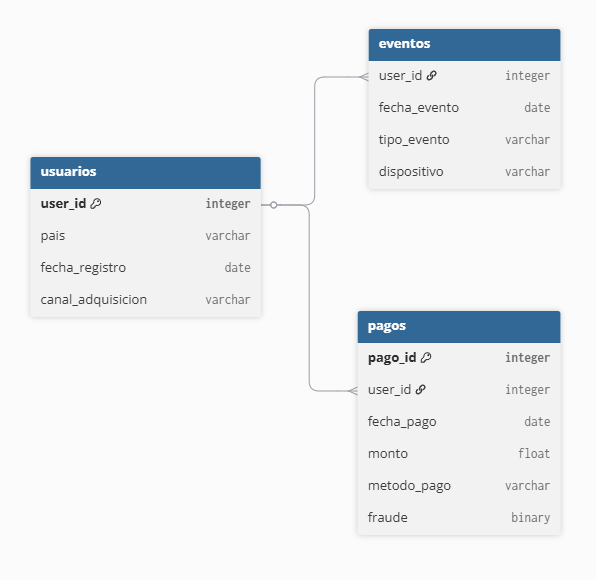

In [35]:
eventos.head()

,user_id,fecha_evento,tipo_evento,dispositivo
0,1,2023-02-06,login,Android
1,1,2023-01-25,compra,Android
2,1,2024-03-27,compra,Web
3,1,2023-02-03,login,Android
4,1,2023-04-29,compra,Web


In [36]:
pagos.head()

,pago_id,user_id,fecha_pago,monto,metodo_pago,fraude
0,1,3387,2024-01-11,25.44,Tarjeta Crédito,0
1,2,3892,2023-07-05,18.53,Tarjeta Crédito,0
2,3,2743,2023-06-28,35.90,Tarjeta Crédito,0
3,4,2935,2023-09-07,0.30,Tarjeta Crédito,0
4,5,3972,2024-06-05,1.48,Débito,0


In [37]:
usuarios.head()

,user_id,pais,fecha_registro,canal_adquisicion
0,1,México,2022-07-24,Orgánico
1,2,Colombia,2023-12-03,Orgánico
2,3,Perú,2023-03-03,Referido
3,4,Perú,2022-03-16,Facebook
4,5,Colombia,2022-06-12,Referido


----------------------------------

# 1. SQL & Modelado de datos

## Ejercicio 1

In [38]:
pagos_por_usuario = pagos.groupby("user_id").agg(ltv_user=("monto", "sum")).reset_index()
usarios_ltv = usuarios.merge(pagos_por_usuario, how="left", on="user_id")
usarios_ltv.groupby("canal_adquisicion").agg(ltv_promedio=("ltv_user", "mean")).reset_index().sort_values("ltv_promedio")

,canal_adquisicion,ltv_promedio
0,Facebook,203.804739
1,Google Ads,204.892044
3,Referido,205.890504
2,Orgánico,208.425704


## Ejercicio 2

In [39]:
eventos["fecha_evento"] = pd.to_datetime(eventos["fecha_evento"], format="%Y-%m-%d")
fecha_lim = eventos["fecha_evento"].max() - pd.Timedelta(days=90)
usarios_activos = eventos.loc[eventos["fecha_evento"] >= fecha_lim, "user_id"].unique()

In [40]:
metodos = pagos.groupby("user_id").agg(metodos_distintos=("metodo_pago", lambda x: len(np.unique(x)))).reset_index()

In [41]:
usuarios_activos_metodos = metodos.loc[(metodos["user_id"].isin(usarios_activos)) & (metodos["metodos_distintos"] >= 2), "user_id"]

In [42]:
usuarios[usuarios["user_id"].isin(usuarios_activos_metodos)].reset_index(drop=True)

,user_id,pais,fecha_registro,canal_adquisicion
0,4,Perú,2022-03-16,Facebook
1,6,Chile,2022-05-10,Referido
2,11,Colombia,2024-02-16,Referido
3,12,Argentina,2022-06-17,Orgánico
4,13,Colombia,2023-02-10,Orgánico
...,...,...,...,...
2101,4992,Perú,2022-05-01,Orgánico
2102,4996,Perú,2024-02-09,Facebook
2103,4997,Perú,2022-11-09,Google Ads
2104,4998,Chile,2023-09-21,Facebook


## Ejercicio 3

In [43]:
eventos["year"] = eventos["fecha_evento"].apply(lambda dt: dt.year)
eventos["week"] = eventos["fecha_evento"].apply(lambda dt: dt.week)

In [44]:
evento_pt = (
    eventos.pivot_table(
        index=["year", "week", "user_id"],
        columns="tipo_evento",
        aggfunc="size",
        fill_value=0
    )
).reset_index()
evento_pt_login = evento_pt[evento_pt["login"] == 1].copy()
evento_pt_login.drop("login", axis=1, inplace=True)

In [45]:
resumen_semana = evento_pt_login.groupby(["year", "week"]).agg(compra=("compra", "sum"), login=("compra", len))
resumen_semana["ratio"] = (resumen_semana["compra"] / resumen_semana["login"])

In [46]:
resumen_semana.reset_index()

,year,week,compra,login,ratio
0,2023,1,5,174,0.028736
1,2023,2,4,174,0.022989
2,2023,3,4,175,0.022857
3,2023,4,2,154,0.012987
4,2023,5,3,166,0.018072
...,...,...,...,...,...
81,2024,30,1,167,0.005988
82,2024,31,4,176,0.022727
83,2024,32,2,171,0.011696
84,2024,33,3,140,0.021429


## Ejercicio 4

Al ser una base de datos que registra transacciones díarias y de forma masiva (OLTP), este modelo de datos deberia atender la 3FN, asegurando integridad en los datos. Posterior a este almacenamiento transaccional, atendiendo determinadas reglas de negocio, se estructura un data warehouse con formacion de estrella ó copo de nieve (OLAP), en el cual se almacena la información de forma historica para su posterior consulta con fines analiticos.

# 2. Feature Engineering + EDA

In [47]:
eventos["tipo_evento"].unique()

array(['login', 'compra', 'cancelacion'], dtype=object)

In [48]:
eventos["dispositivo"].unique()

array(['Android', 'Web', 'iOS'], dtype=object)

In [49]:
pagos["metodo_pago"].unique()

array(['Tarjeta Crédito', 'Débito', 'Crypto', 'PayPal'], dtype=object)

In [50]:
usuarios["canal_adquisicion"].unique()

array(['Orgánico', 'Referido', 'Facebook', 'Google Ads'], dtype=object)

In [51]:
pagos["fraude"].value_counts()

fraude
0    19023
1      977
Name: count, dtype: int64

## Tarea 1

En la tablas eventos previamente se han agregado la columna de año y semana

In [52]:
# Se ajusta el formato a las fechas
eventos["fecha_evento"] = pd.to_datetime(eventos["fecha_evento"], format="%Y-%m-%d")
pagos["fecha_pago"] = pd.to_datetime(pagos["fecha_pago"], format="%Y-%m-%d")
usuarios["fecha_registro"] = pd.to_datetime(usuarios["fecha_registro"], format="%Y-%m-%d")


In [53]:
# Se carga una columna que indica el mes de la fecha
eventos["month"] = eventos["fecha_evento"].apply(lambda dt: dt.month)
pagos["month"]   = pagos["fecha_pago"].apply(lambda dt: dt.month)
usuarios["month"] = usuarios["fecha_registro"].apply(lambda dt: dt.month)

# Se carga una columna que indica el día de la fecha
eventos["day"] = eventos["fecha_evento"].apply(lambda dt: dt.day)
pagos["day"]   = pagos["fecha_pago"].apply(lambda dt: dt.day)
usuarios["day"] = usuarios["fecha_registro"].apply(lambda dt: dt.day)

# (Opcional) Si quieres el año y la semana también:
eventos["year"]  = eventos["fecha_evento"].apply(lambda dt: dt.year)
pagos["year"]    = pagos["fecha_pago"].apply(lambda dt: dt.year)
usuarios["year"] = usuarios["fecha_registro"].apply(lambda dt: dt.year)

eventos["week"]  = eventos["fecha_evento"].apply(lambda dt: dt.isocalendar()[1])
pagos["week"]    = pagos["fecha_pago"].apply(lambda dt: dt.isocalendar()[1])
usuarios["week"] = usuarios["fecha_registro"].apply(lambda dt: dt.isocalendar()[1])


In [54]:
# Se agrega una columna fds (fin de semana), indicando 1 si el 
# día del evento es sábado o domingo, 0 en caso contratio
eventos["fds"] = eventos["fecha_evento"].apply(lambda dt: 1 if dt.weekday() in [6, 7] else 0)
pagos["fds"] = pagos["fecha_pago"].apply(lambda dt: 1 if dt.weekday() in [6, 7] else 0)
usuarios["fds"] = usuarios["fecha_registro"].apply(lambda dt: 1 if dt.weekday() in [6, 7] else 0)

# Se agrega una columna fdq (fin de quincena) que señala 
# los días 29, 30, 31, 1, 14, 15, 16 de cada mes
eventos["fdq"] = eventos["fecha_evento"].apply(lambda dt: 1 if dt.day in [29, 30, 31, 1, 14, 15, 16] else 0)
pagos["fdq"] = pagos["fecha_pago"].apply(lambda dt: 1 if dt.day in [29, 30, 31, 1, 14, 15, 16] else 0)
usuarios["fdq"] = usuarios["fecha_registro"].apply(lambda dt: 1 if dt.day in [29, 30, 31, 1, 14, 15, 16] else 0)

In [55]:
pagos.loc[pagos["fds"] == 1].groupby("metodo_pago")["monto"].mean()

metodo_pago
Crypto             43.483077
Débito             51.816060
PayPal             51.057039
Tarjeta Crédito    49.969345
Name: monto, dtype: float64

In [56]:
pagos.loc[pagos["fds"] == 0].groupby("metodo_pago")["monto"].mean()

metodo_pago
Crypto             52.184705
Débito             50.434760
PayPal             51.473637
Tarjeta Crédito    49.999325
Name: monto, dtype: float64

In [57]:
eventos.head()

,user_id,fecha_evento,tipo_evento,dispositivo,year,week,month,day,fds,fdq
0,1,2023-02-06,login,Android,2023,6,2,6,0,0
1,1,2023-01-25,compra,Android,2023,4,1,25,0,0
2,1,2024-03-27,compra,Web,2024,13,3,27,0,0
3,1,2023-02-03,login,Android,2023,5,2,3,0,0
4,1,2023-04-29,compra,Web,2023,17,4,29,0,1


In [58]:
pagos.head()

,pago_id,user_id,fecha_pago,monto,metodo_pago,fraude,month,day,year,week,fds,fdq
0,1,3387,2024-01-11,25.44,Tarjeta Crédito,0,1,11,2024,2,0,0
1,2,3892,2023-07-05,18.53,Tarjeta Crédito,0,7,5,2023,27,0,0
2,3,2743,2023-06-28,35.90,Tarjeta Crédito,0,6,28,2023,26,0,0
3,4,2935,2023-09-07,0.30,Tarjeta Crédito,0,9,7,2023,36,0,0
4,5,3972,2024-06-05,1.48,Débito,0,6,5,2024,23,0,0


In [59]:
usuarios.head()

,user_id,pais,fecha_registro,canal_adquisicion,month,day,year,week,fds,fdq
0,1,México,2022-07-24,Orgánico,7,24,2022,29,1,0
1,2,Colombia,2023-12-03,Orgánico,12,3,2023,48,1,0
2,3,Perú,2023-03-03,Referido,3,3,2023,9,0,0
3,4,Perú,2022-03-16,Facebook,3,16,2022,11,0,1
4,5,Colombia,2022-06-12,Referido,6,12,2022,23,1,0


## Tarea 2

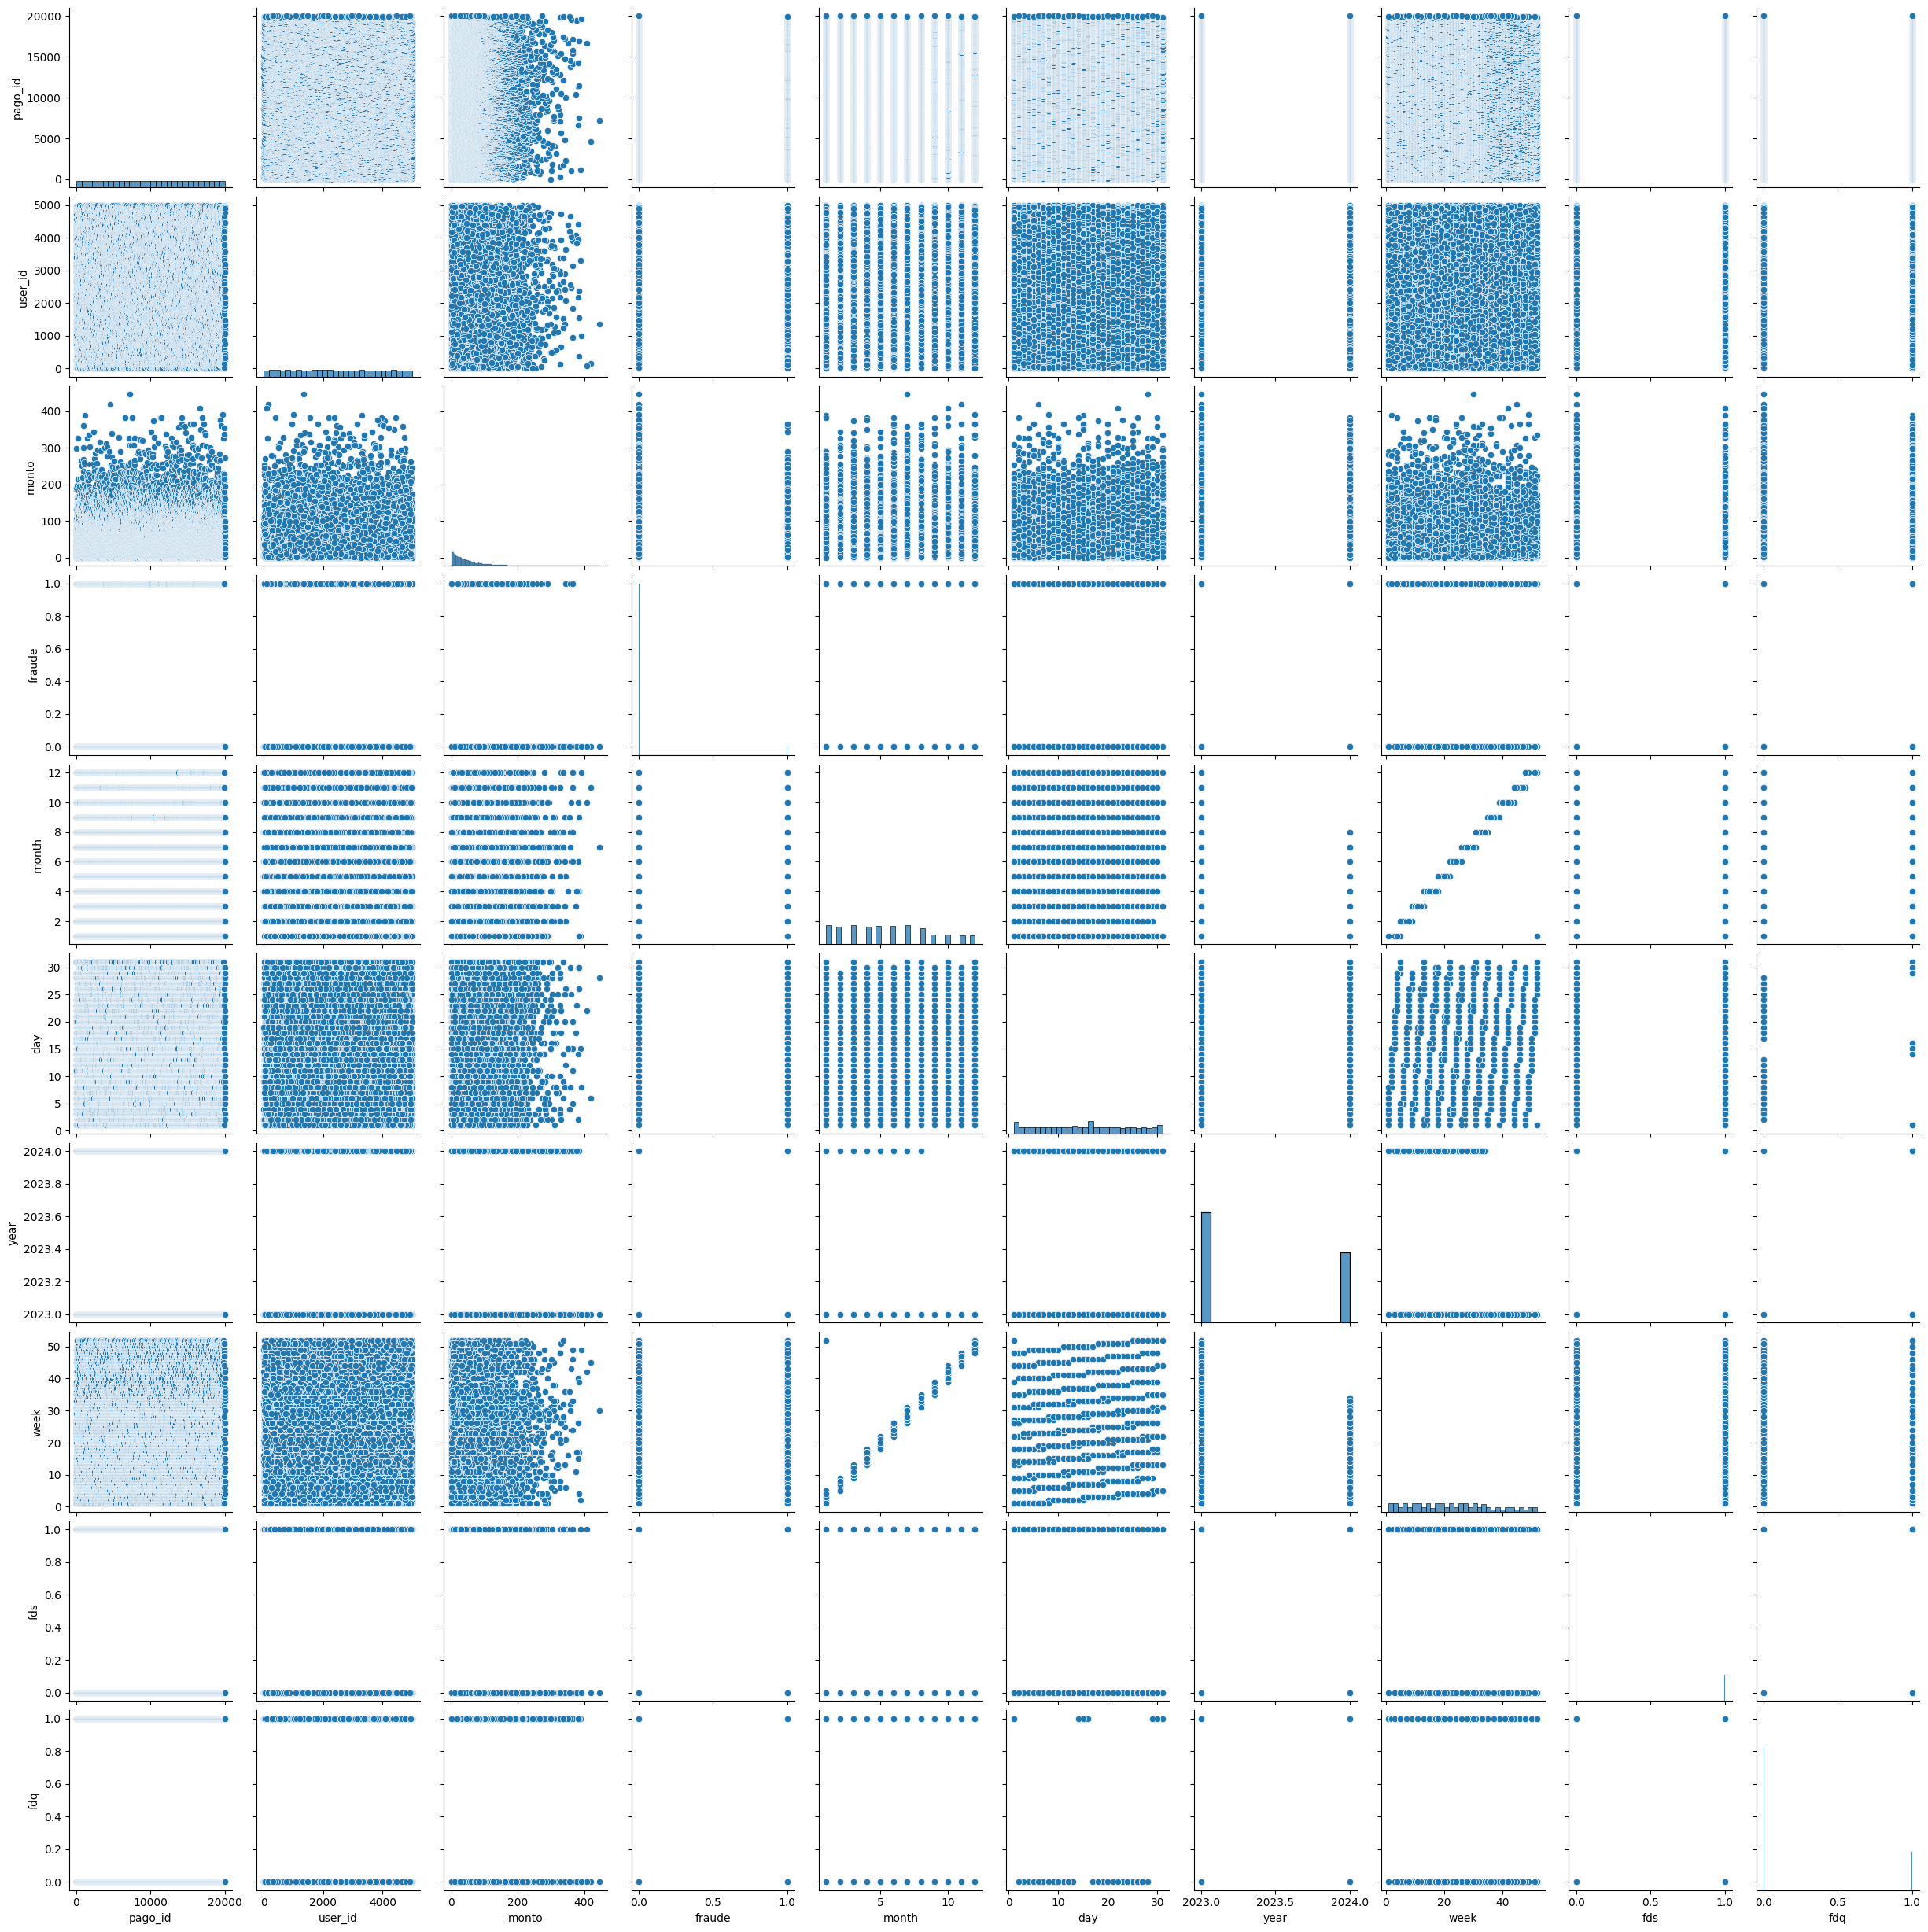

In [60]:
sns.pairplot(data=pagos)
plt.show()

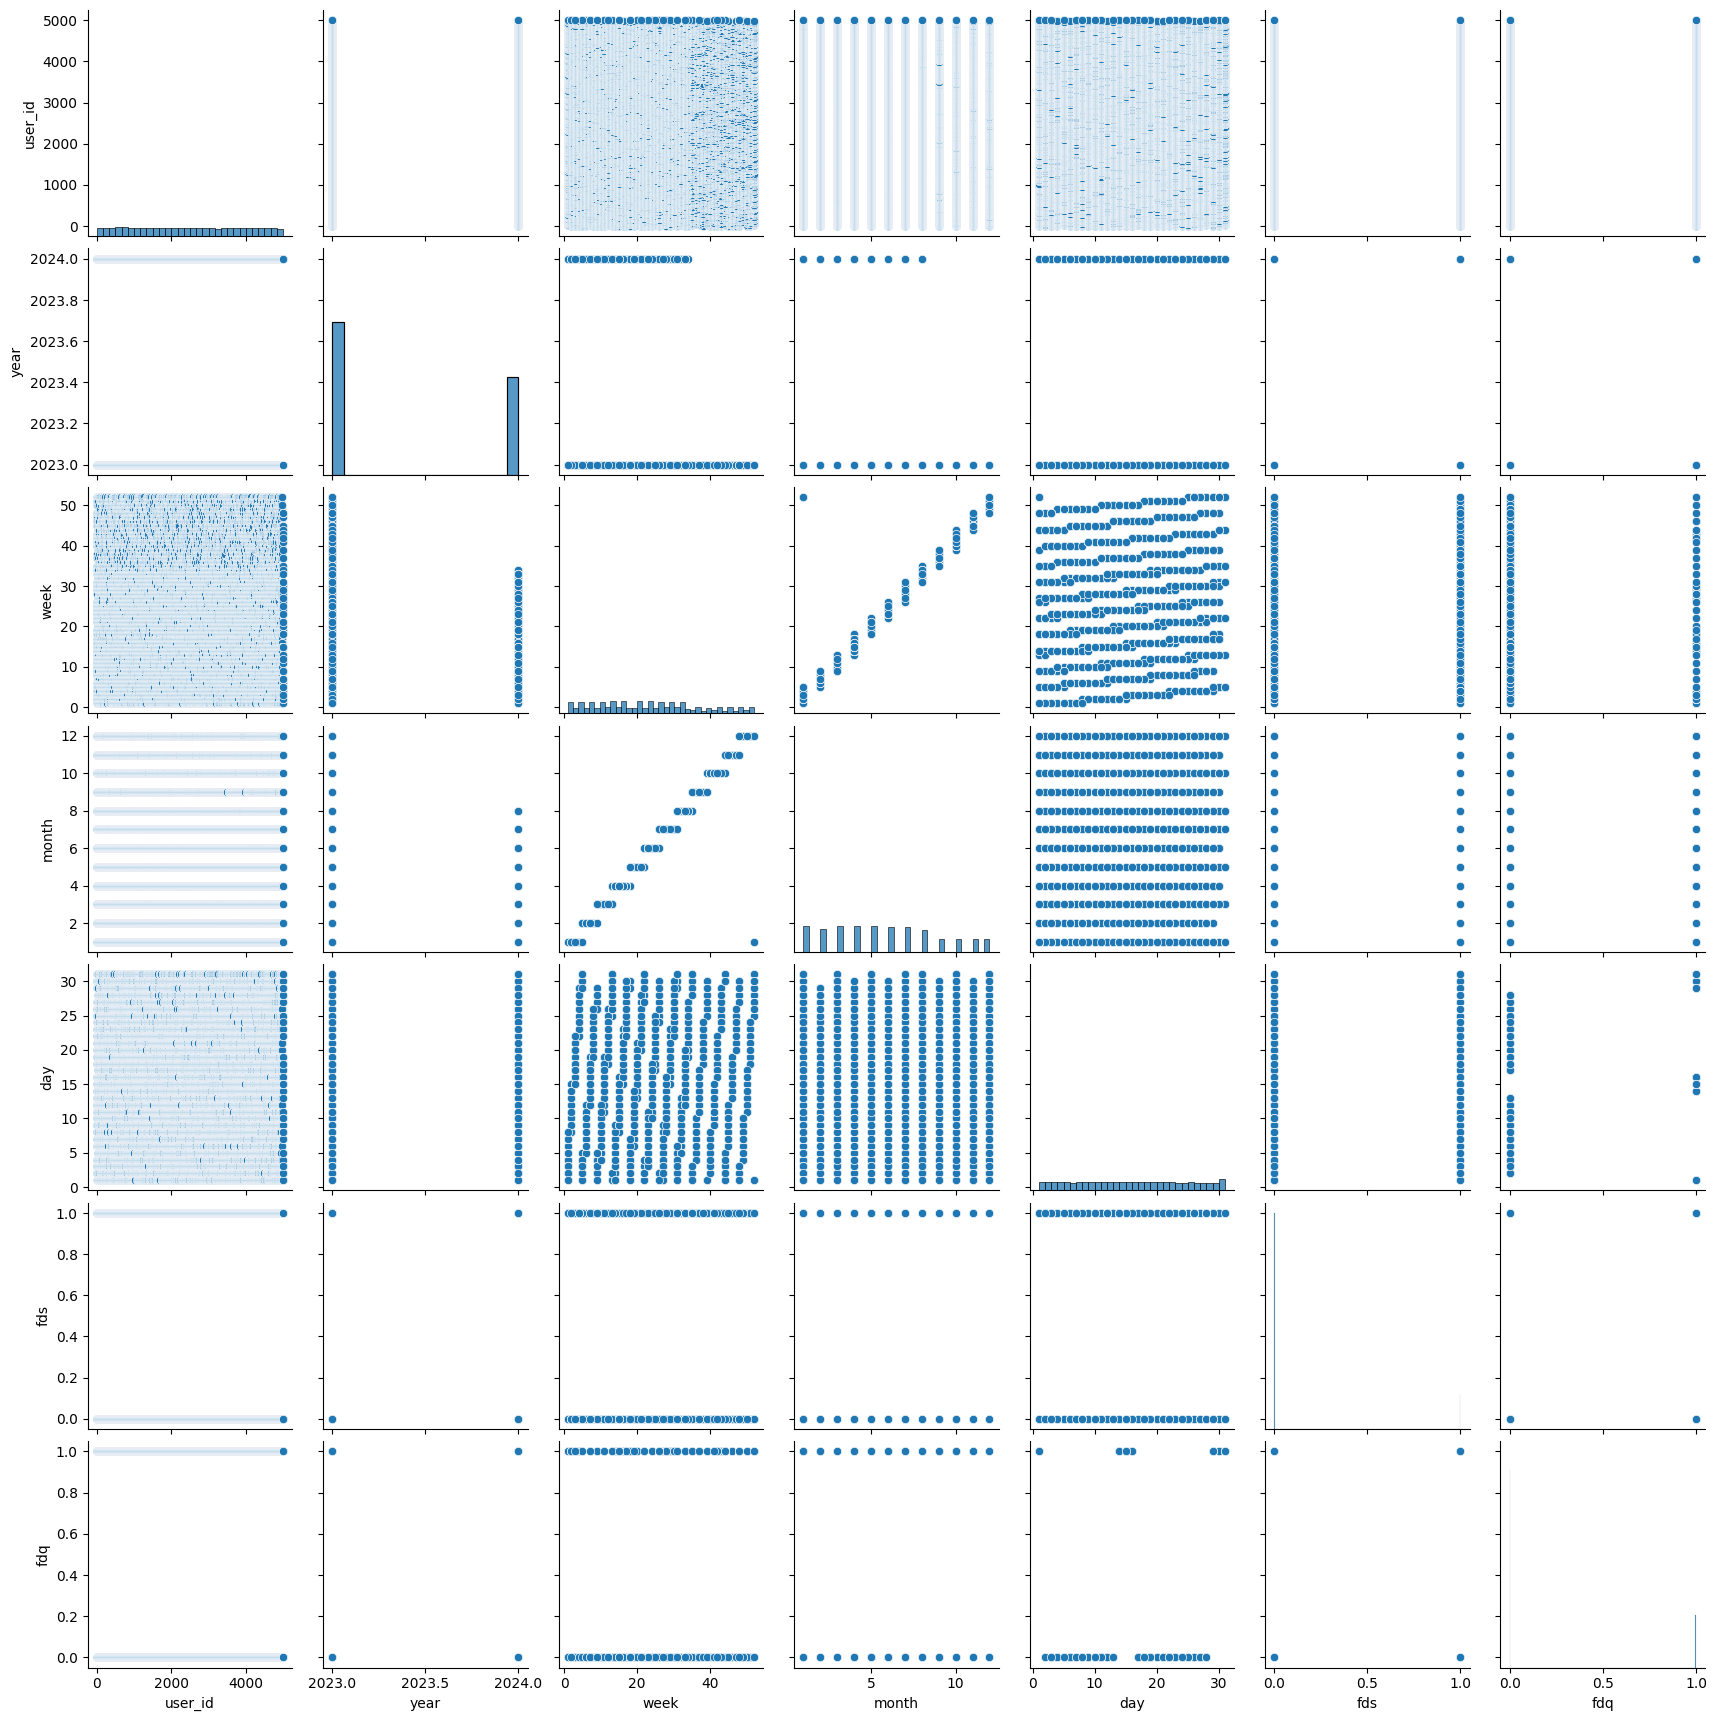

In [61]:
sns.pairplot(data=eventos)
plt.show()

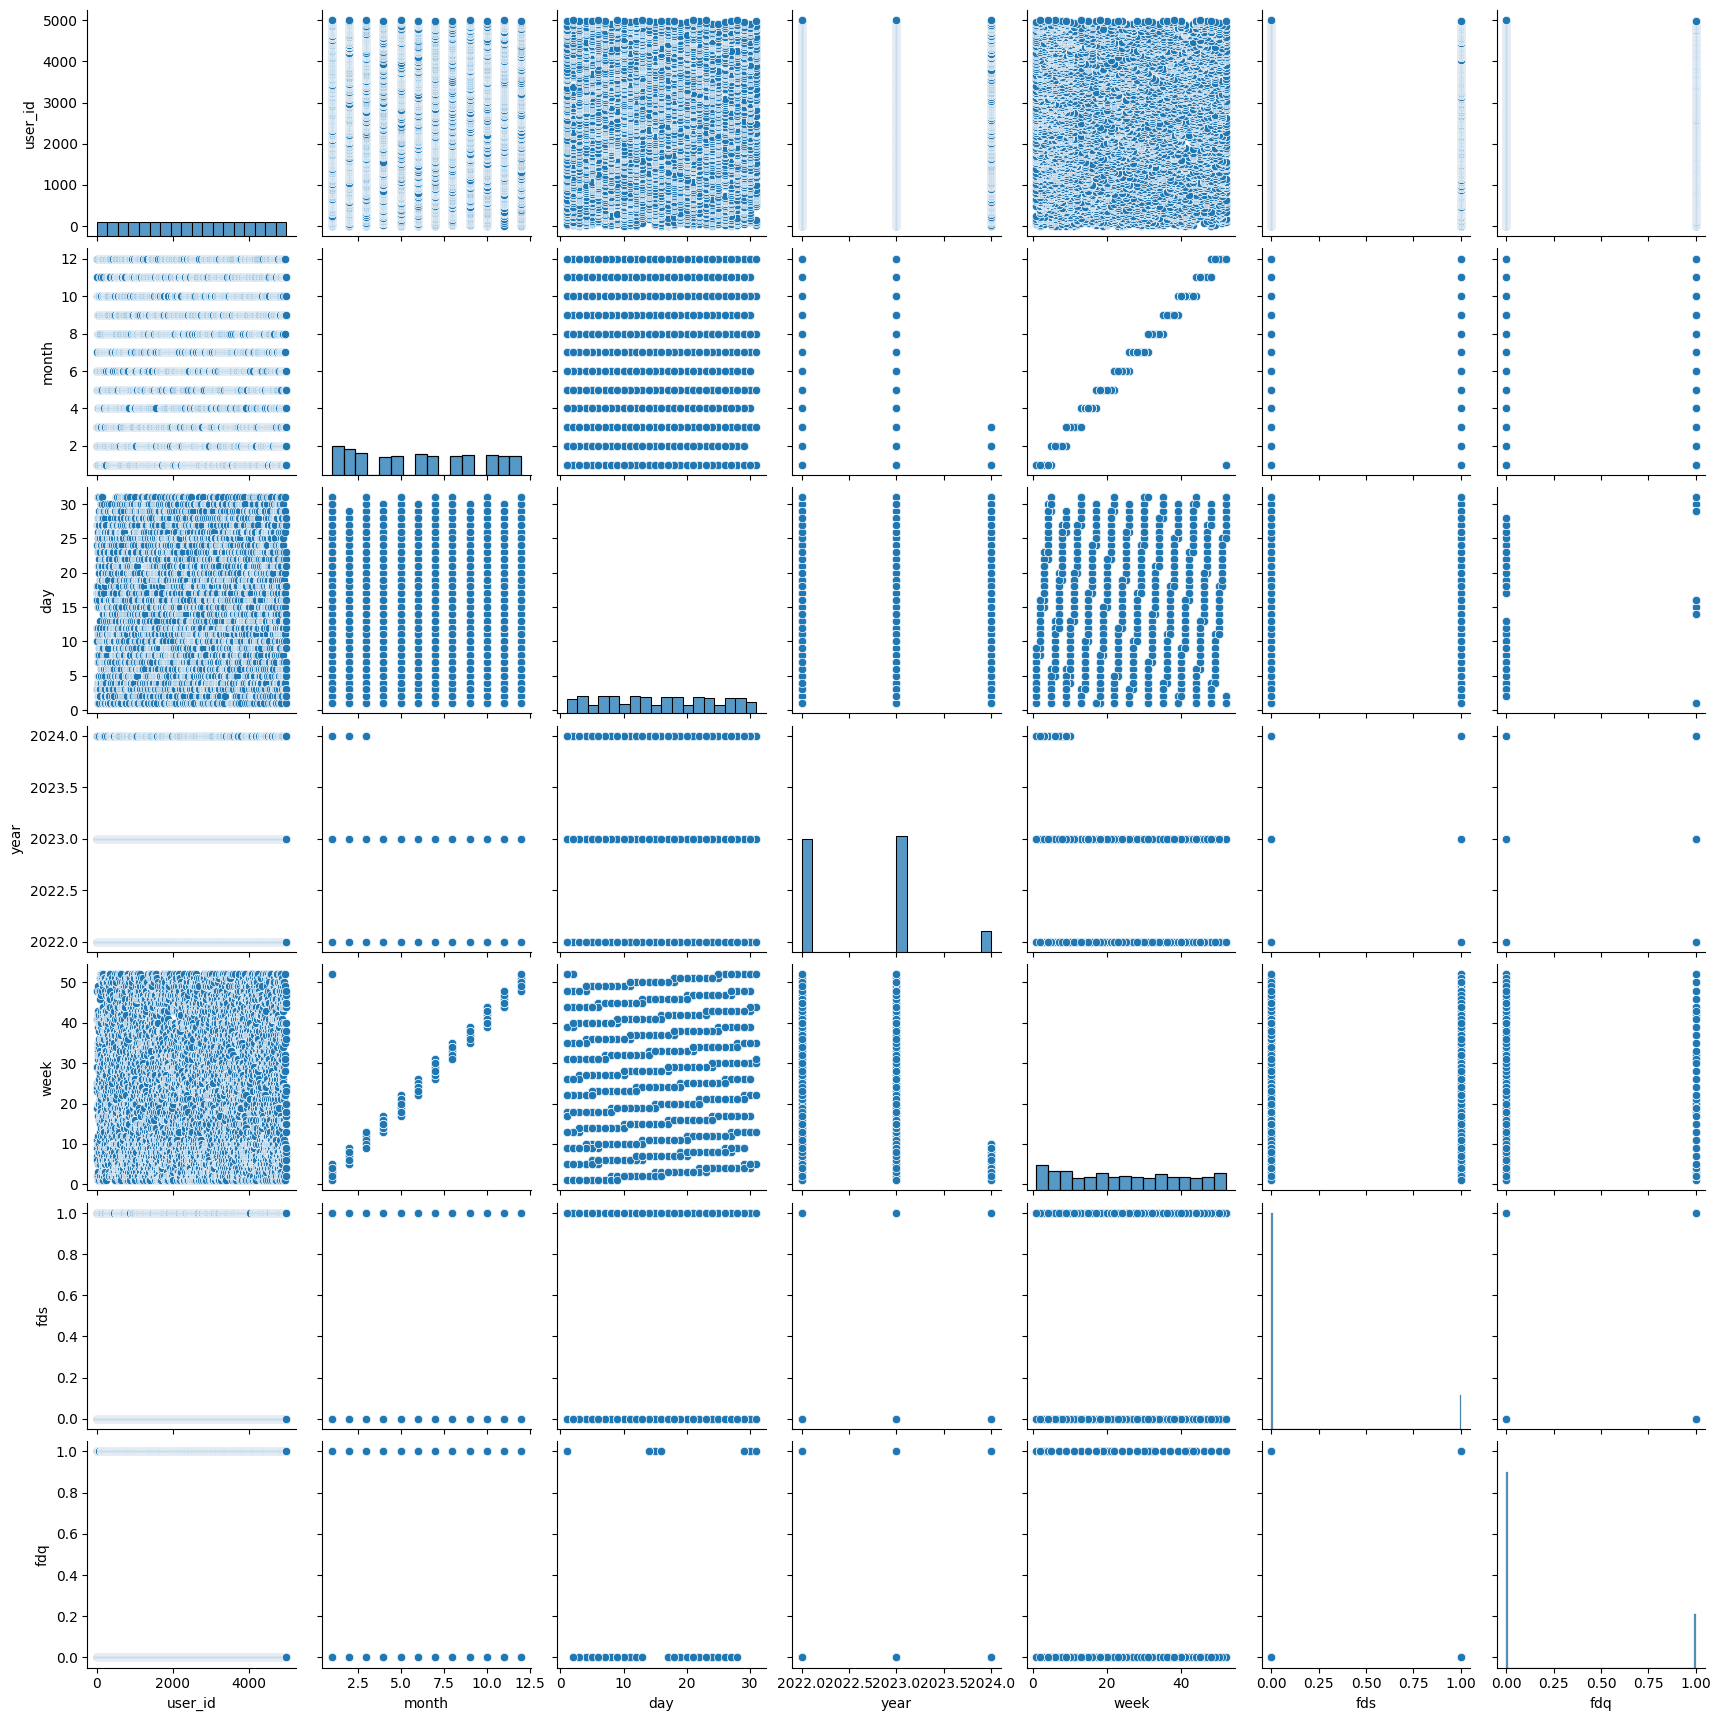

In [62]:
sns.pairplot(data=usuarios)
plt.show()

Se presenta gran correlación de las variables temporales generadas de forma reciente (year, month, ...), estas son generadas con el proposito de realizar análisis más detallados y obtener metricas de tiempos concretos. Lo que corresponde con estas variables, es una vez realizado en análisis u obtenido la métrica concreta, eliminarlas para evitar redundancia en la información almacenada historicamente.


## Tarea 3

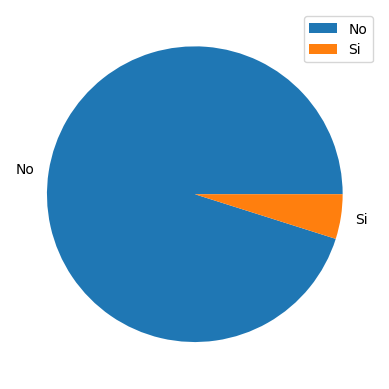

In [63]:
plt.pie(pagos["fraude"].value_counts(), labels=["No", "Si"])
plt.legend()
plt.show()

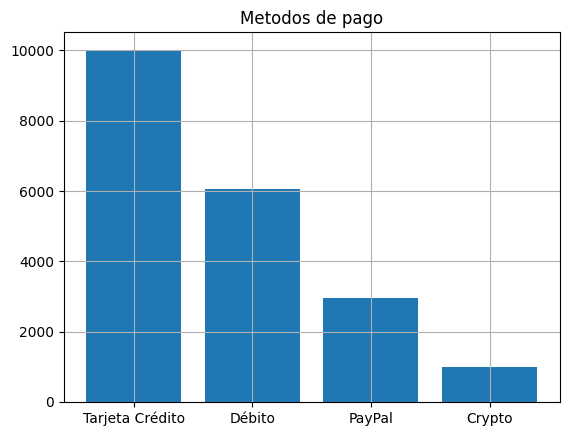

In [64]:
plt.bar(
pagos["metodo_pago"].value_counts().index,
pagos["metodo_pago"].value_counts(),
)
plt.grid()
plt.title("Metodos de pago")
plt.show()

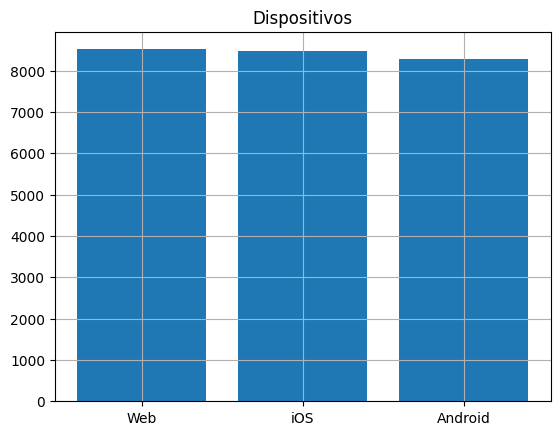

In [65]:
plt.bar(
eventos["dispositivo"].value_counts().index,
eventos["dispositivo"].value_counts(),
)
plt.title("Dispositivos")
plt.grid()
plt.show()

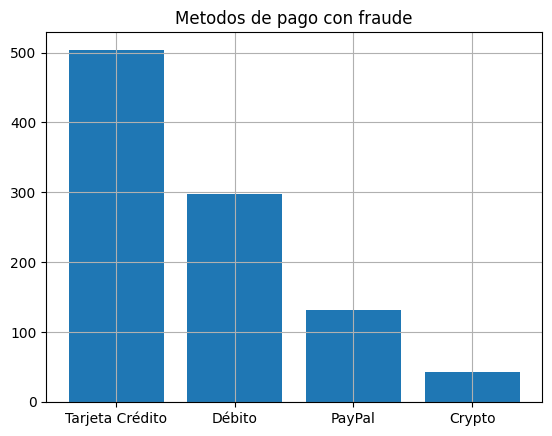

In [66]:
plt.bar(
pagos.loc[pagos["fraude"] == 1, "metodo_pago"].value_counts().index,
pagos.loc[pagos["fraude"] == 1, "metodo_pago"].value_counts(),
)
plt.title("Metodos de pago con fraude")
plt.grid()
plt.show()

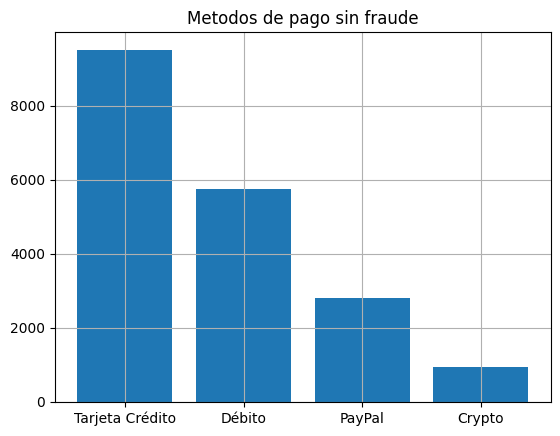

In [67]:
plt.bar(
pagos.loc[pagos["fraude"] == 0, "metodo_pago"].value_counts().index,
pagos.loc[pagos["fraude"] == 0, "metodo_pago"].value_counts(),
)
plt.title("Metodos de pago sin fraude")
plt.grid()
plt.show()

In [68]:
pais_fraude_1 = pagos.loc[pagos["fraude"] == 0,[ "user_id"]].merge(usuarios[["user_id", "pais"]], how="left", on="user_id")
pais_fraude_0 = pagos.loc[pagos["fraude"] == 0,[ "user_id"]].merge(usuarios[["user_id", "pais"]], how="left", on="user_id")

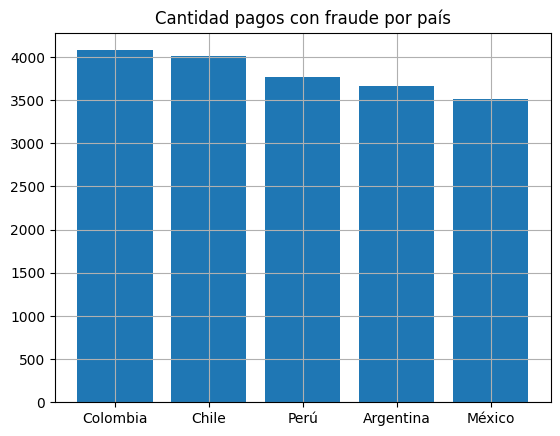

In [69]:
plt.bar(
pais_fraude_1["pais"].value_counts().index,
pais_fraude_1["pais"].value_counts(),
)
plt.title("Cantidad pagos con fraude por país")
plt.grid()
plt.show()

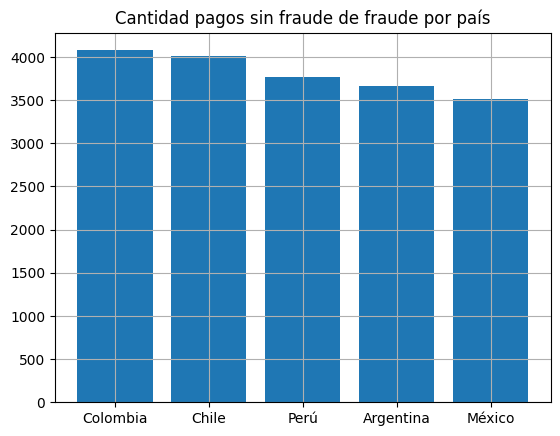

In [70]:
plt.bar(
pais_fraude_0["pais"].value_counts().index,
pais_fraude_0["pais"].value_counts(),
)
plt.title("Cantidad pagos sin fraude de fraude por país")
plt.grid()
plt.show()

In [71]:
print(f"Fraude: {100 * (pagos['fraude'].sum() / pagos.shape[0]):.2f} %")

Fraude: 4.88 %


In [72]:
100 * (pagos["metodo_pago"].value_counts() / pagos.shape[0])

metodo_pago
Tarjeta Crédito    50.090
Débito             30.225
PayPal             14.720
Crypto              4.965
Name: count, dtype: float64

En la exploración de datos, en la tabla `pagos`, en la columna `[fraude]` se indica `1` para positivo, y `0` para negativo, sin embargo, los valores positivos son apenas un $4.88\%$ de los datos registrados, mostrando un dataset altamente desvalanceado, conllevando un gran riesgo de que modelos predictivos aprendan a predecir siempre `0`.
Por otro lado, en la misma tabla de `pagos`, en la columna `[metodo_pago]` se indica que poco más de la mitad de los pagos son relaizados con `Tarjeta Crédito` con un $50.09\%$, mientras que los pagos con `Crypto` representa un $4.96%$ de la información registrada, lo que complica la capacidad de generalizar patrones de fraude en estos metodos tan pocos representados.

$H_0$: En todos los paises el dispositivo predominante es el mismo.

$H_1$: Existe un país donde el dispositivo predominante es diferentes al resto de los paises.

In [73]:
m_pago_disp = eventos[["user_id", "dispositivo"]].merge(usuarios[["user_id", "pais"]], "left", "user_id")

In [74]:
m_pago_disp.pivot_table(index="dispositivo", columns="pais", aggfunc=len)

user_id                            
pais        Argentina Chile Colombia México  Perú
dispositivo                                      
Android          1631  1741     1741   1526  1651
Web              1664  1776     1847   1557  1673
iOS              1674  1794     1793   1522  1703

Se observa que en Peru, la mayoria de los eventos son registrados en dispositivos **iOS**, mientras que en Colombia, la mayoria de los eventos se registran en la **Web**.

# 3. Machine Learning + Interpretabilidad

In [75]:
# us_pa = usuarios.iloc[:,:-6].merge(pagos.iloc[:,:-6], 'left', "user_id")
us_pa = (usuarios.iloc[:,:-6]
         .merge(pagos, 'left', "user_id")
         .merge(eventos.loc[eventos["tipo_evento"] == "compra", ["user_id", "dispositivo"]], "left", "user_id"))

In [76]:
us_pa.head()

,user_id,pais,fecha_registro,canal_adquisicion,pago_id,fecha_pago,monto,metodo_pago,fraude,month,day,year,week,fds,fdq,dispositivo
0,1,México,2022-07-24,Orgánico,402.0,2024-05-10,8.64,Crypto,0.0,5.0,10.0,2024.0,19.0,0.0,0.0,Android
1,1,México,2022-07-24,Orgánico,402.0,2024-05-10,8.64,Crypto,0.0,5.0,10.0,2024.0,19.0,0.0,0.0,Web
2,1,México,2022-07-24,Orgánico,402.0,2024-05-10,8.64,Crypto,0.0,5.0,10.0,2024.0,19.0,0.0,0.0,Web
3,1,México,2022-07-24,Orgánico,402.0,2024-05-10,8.64,Crypto,0.0,5.0,10.0,2024.0,19.0,0.0,0.0,Web
4,1,México,2022-07-24,Orgánico,4046.0,2024-05-07,63.46,Tarjeta Crédito,0.0,5.0,7.0,2024.0,19.0,0.0,0.0,Android


In [77]:
us_pa = us_pa[~ us_pa["pago_id"].isna()]

In [78]:
us_pa.describe(include="object")

,pais,canal_adquisicion,metodo_pago,dispositivo
count,38601,38601,38601,35243
unique,5,4,4,3
top,Colombia,Google Ads,Tarjeta Crédito,iOS
freq,8423,9834,19361,11976


## Tarea 1

In [79]:
X = us_pa[["pais", "canal_adquisicion", "monto", "metodo_pago", "month", "day", "fds", "fdq"]]
y = us_pa["fraude"]

# Columnas categóricas
cat_features = ["pais", "canal_adquisicion", "metodo_pago"]
# Columnas numéricas
num_features = ["monto", "month", "day"]

In [ ]:
# ===============================
# 4. Entrenamiento
# ===============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

## Tarea 3

In [81]:
# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(handle_unknown="ignore"), cat_features),
        ("numerical", StandardScaler(), num_features)
    ]
)

### pipeline 1

In [ ]:
# ===============================
# 3. Pipeline con árbol de decisión
# ===============================
pipeline1 = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("undersample", RandomUnderSampler(sampling_strategy=1.0, random_state=SEED)),
    ("classifier", DecisionTreeClassifier(random_state=SEED))
])

In [83]:

pipeline1.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('undersample', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical', ...), ('numerical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [91]:

print(f"Porcentaje de acieto: {100 * pipeline1.score(X_test, y_test):.2f} %")

Porcentaje de acieto: 65.22 %


In [86]:
y_pred = pipeline1.predict(X_test)

In [88]:
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)

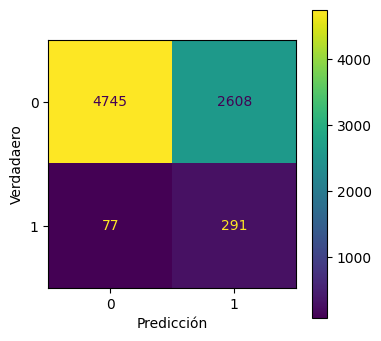

In [90]:
fig , ax = plt.subplots(figsize = (4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax = ax)
ax.set_xlabel("Predicción")
ax.set_ylabel("Verdadaero")
# ax.set_xticklabels([1, 0])
plt.show()

### pipeline 2

In [ ]:
# Modelos base
lr = LogisticRegression(max_iter=500, class_weight="balanced")
gb = GradientBoostingClassifier(n_estimators=200, random_state=SEED)


# Ensemble (Voting: combina ambos modelos)
voting_clf = VotingClassifier(
    estimators=[("lr", lr), ("gb", gb)],
    voting="soft"  # promediar probabilidades
)

In [ ]:
# Pipeline: escalado + undersampling + ensemble
pipeline2 = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("undersample", RandomUnderSampler(sampling_strategy=1.0, random_state=SEED)),
    ("ensemble", voting_clf)
])

In [97]:

pipeline2.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('undersample', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical', ...), ('numerical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [98]:

print(f"Porcentaje de acieto: {100 * pipeline2.score(X_test, y_test):.2f} %")

Porcentaje de acieto: 58.09 %


In [99]:
y_pred = pipeline2.predict(X_test)

In [100]:
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)

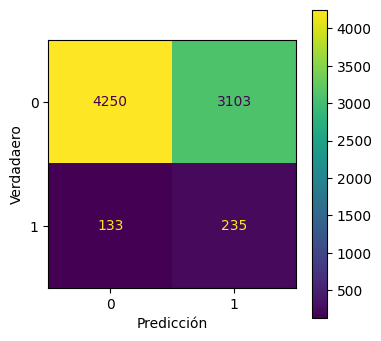

In [101]:
fig , ax = plt.subplots(figsize = (4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax = ax)
ax.set_xlabel("Predicción")
ax.set_ylabel("Verdadaero")
# ax.set_xticklabels([1, 0])
plt.show()

## Tarea 4